# `DecisionTreeClassifier` - HyperparameterTuning

In [5]:
from sklearn.tree import DecisionTreeClassifier
from src.preprocessing import Passthrough
from sklearn.pipeline import Pipeline, make_pipeline
from src.utils import print_params
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

## Load the data

In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv("../../data/raw/train.csv")
dfX = df.drop(['Survived', 'PassengerId'],axis=1)
dfy = df.Survived

## Import the `DataPipeline`

In [7]:
from src.pipeline import dp1 as dp

In [8]:
dp.get_description(markdown=True)


1. Drop Name, Ticket - requires Feature Engineering
2. OneHotEncoder for Sex, Embarked
3. Drop Cabin - requires Feature Engineering/(?And Not Imputation)
4. Age : Applied Mean Imputation and Mean Normalization
5. Drop NaN rows in Embarked
6. Applied StandardScaler at the end to all features

MLmodel: SVC

In [9]:
dp.set_data(df)
dfX_pre, dfy_pre = dp.prepare()

In [10]:
dp.mlmodel = DecisionTreeClassifier()

## `prepare` and `preprocess`

In [11]:
dp.set_data(df)
dfX_pre, dfy_pre = dp.prepare()
dp.preprocess()

array([[ 0.73534203, -0.30794088,  0.61679395, ...,  0.43135024,
        -0.47432585, -0.50023975],
       [-1.35991138, -0.30794088, -1.62128697, ...,  0.43135024,
        -0.47432585,  0.78894661],
       [-1.35991138, -0.30794088,  0.61679395, ..., -0.47519908,
        -0.47432585, -0.48664993],
       ...,
       [-1.35991138, -0.30794088,  0.61679395, ...,  0.43135024,
         2.00611934, -0.17408416],
       [ 0.73534203, -0.30794088, -1.62128697, ..., -0.47519908,
        -0.47432585, -0.0422126 ],
       [ 0.73534203,  3.24737656, -1.62128697, ..., -0.47519908,
        -0.47432585, -0.49017322]])

## Fit the `DecisionTreeClassifier` and get the `tree`

In [12]:
dp.fit()
tree = dp.mlmodel.tree_

## Let' see the `max_depth` reached when it's set to None

In [13]:
max_depth_train = tree.max_depth
max_depth_train

20

In [14]:
dp.score()

1.0

#### Function to reasonable values for `max_depth`

In [15]:
def get_max_depth_vals(max_depth, nvals=5):
    return np.ceil((2**np.linspace(np.log2(4), np.log2(max_depth*1.5), nvals)))

max_depth = get_max_depth_vals(max_depth_train)
max_depth

array([ 4.,  7., 11., 19., 31.])

In [18]:
import matplotlib.pyplot as plt

Object `function` not found.


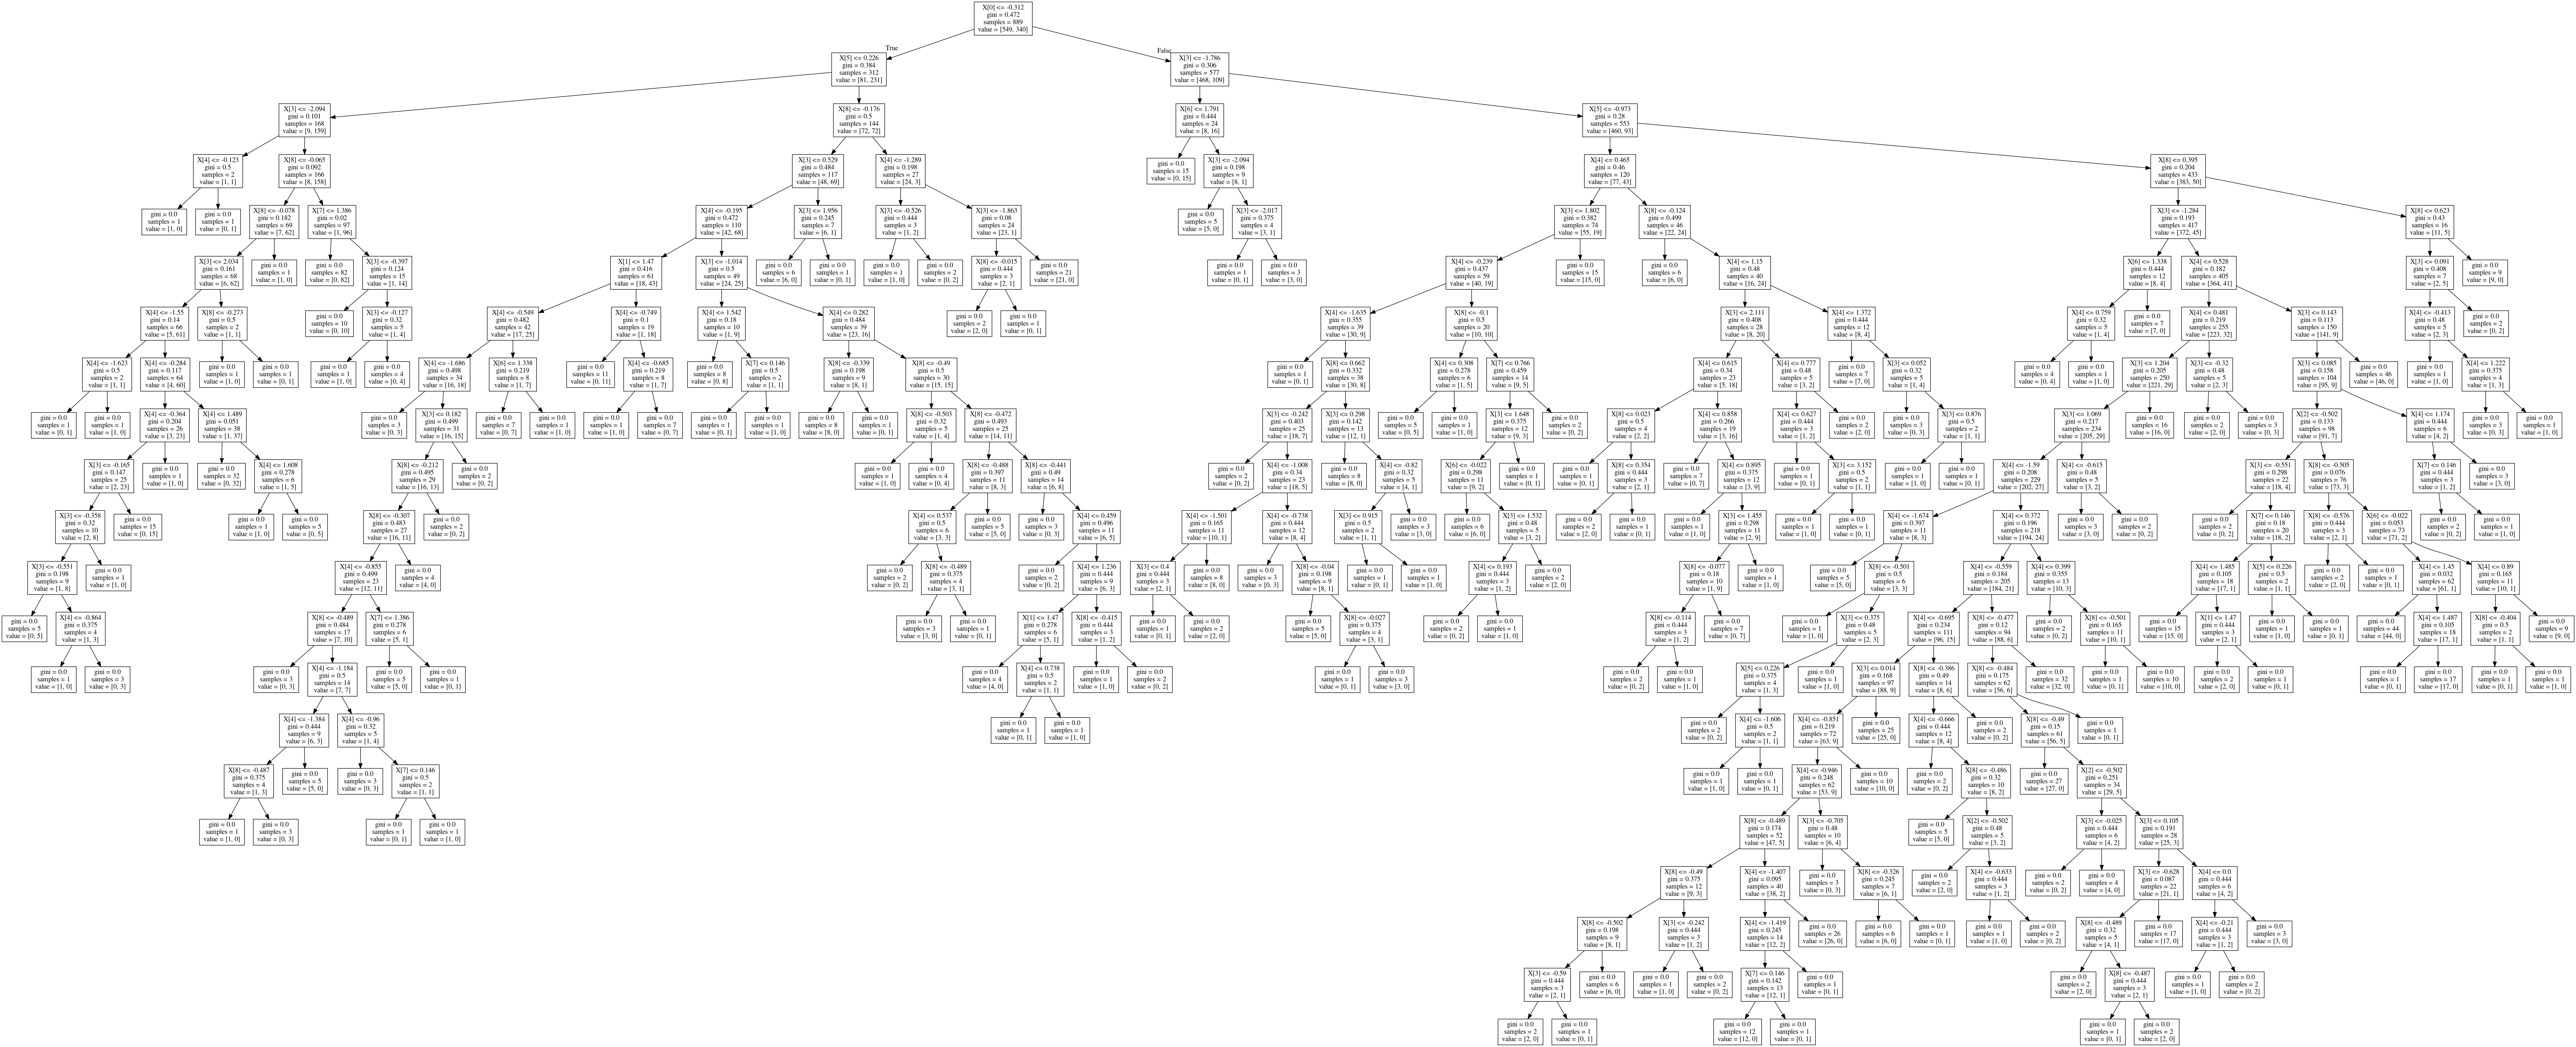

In [78]:
from io import StringIO
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz

Maybe make this into a draw_decision_tree function?

out = StringIO() # create output-object
export_graphviz(dp.mlmodel, out_file=out) # export dotdata to object
graph = pydot.graph_from_dot_data(out.getvalue())[0] # make a graph from dotdata
Image(graph.create_png()) # create png byte data from graph and visualize using Image


## Generate the `temp_grid`

In [22]:
temp_grid = {}

In [23]:
from src.utils import param_from_temp_grid

In [42]:
dfX_pre.shape[0]*0.005

4.445

## Get the `param_grid`

In [51]:
from sklearn.model_selection import ParameterGrid

In [65]:
param_grid = param_from_temp_grid(temp_grid)
param_grid

[{'ml': [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                          max_depth=None, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, presort='deprecated',
                          random_state=None, splitter='best')],
  'ml__max_depth': array([ 4.,  7., 11., 19., 31.]),
  'ml__min_samples_split': [2, 5, 10, 20, 40],
  'ml__min_samples_leaf': [2, 5, 10, 20, 40],
  'ml__max_features': ['sqrt', 'log2', None, 0.1, 0.3, 0.5, 0.7]}]

### Check the length of the `param_grid`. Is it too big for `GridSearchCV`?

In [53]:
len(ParameterGrid(param_grid))

875

### Take out the `pipeline`

In [54]:
pipe = dp.get_pipeline()

In [66]:
%%time
pipe.fit(dfX_pre, dfy_pre);

CPU times: user 29 ms, sys: 46 µs, total: 29 ms
Wall time: 28.6 ms


Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('clmn_trnsfrm',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='passthrough',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('clmn_drp',
                                                                   'drop',
                                                                   ['Name',
                                                                    'Ticket',
                                                                    'Cabin']),
                                                                  ('enc',
                                                                   OneHotEncoder(categories='auto',
   

## `RandomizedSearchCV`

In [21]:
skf = StratifiedKFold(n_splits=5)

In [23]:
%%time
grid_search = GridSearchCV(pipe, param_grid, cv=skf)
grid_search.fit(dfX_pre, dfy_pre)

NameError: name 'pipe' is not defined

In [64]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'ml': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7.0, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'ml__max_depth': 7.0, 'ml__max_features': None, 'ml__min_samples_leaf': 5, 'ml__min_samples_split': 5}
0.8256586047102139
